In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import auc,make_scorer,classification_report,f1_score,accuracy_score, average_precision_score, roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from inspect import signature
from scipy import interp

In [35]:
def Draw_ROC(Y_prob, Y_observed, model_name = 'ANN'):
    ns_probs = [0 for _ in range(len(Y_observed))]
    # calculate scores
    ns_auc = roc_auc_score(Y_observed, ns_probs)
    lr_auc = roc_auc_score(Y_observed, Y_prob)
    # summarize scores
    print('Chance: ROC AUC=%.3f' % (ns_auc))
    print('%s: ROC AUC=%.3f' % (model_name, lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(Y_observed, ns_probs, pos_label=1)
    lr_fpr, lr_tpr, _ = roc_curve(Y_observed, Y_prob, pos_label=1)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Chance')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.title('Receiver operating characteristic curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()


In [36]:
def Draw_PR(Y_prob, Y_predicted, Y_observed, model_name = 'ANN'):
    # predict class values
    lr_precision, lr_recall, _ = precision_recall_curve(Y_observed, Y_prob, pos_label=1)
    lr_f1, lr_auc = f1_score(Y_observed, Y_predicted), auc(lr_recall, lr_precision)
    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(Y_observed[Y_observed==1]) / len(Y_observed)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Chance')
    plt.plot(lr_recall, lr_precision, marker='.', label=model_name)
    # axis labels
    plt.title('2-class Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [39]:
def ANN():
    df_train = pd.read_csv('../Data/train.csv')
    df_test = pd.read_csv('../Data/validation.csv')
    
    df_test_under = pd.read_csv('../Data/validation_under.csv')
    
    # preprocessing data    
    df_train_data = df_train.drop(columns = ['Amount','Class'])
    df_train_result = df_train['Class']
    df_train_result = to_categorical(df_train_result)
    
    df_test_data = df_test.drop(columns = ['Amount','Class'])
    df_test_result = df_test['Class']
    
    df_test_under_data = df_test_under.drop(columns = ['Amount','Class'])
    df_test_under_result = df_test_under['Class']


    df_test_result = to_categorical(df_test_result)
    epochs = 1
    #create ANN model
    model = Sequential([
        Dense(64, kernel_initializer='glorot_normal',
                bias_initializer='zeros',input_shape=(16,),activation = 'relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros', activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(2,activation='softmax')
        ])
    
    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy']
        )
    epoch = epochs   # should be 450 - 500
    batch_size = 2048
    model.fit(df_train_data,df_train_result,epochs = epoch, batch_size = batch_size)
    
    #prediction
    df_test_pred = model.predict(df_test_data)
    pred = np.argmax(df_test_pred, axis=1).tolist()
    print('CLASSIFICATION REPORT')
    df_test_report = df_test['Class'].tolist()
    print(classification_report(df_test_report, pred))
    
    #undersample prediction
    df_test_under_pred = model.predict(df_test_under_data)
    pred_under = np.argmax(df_test_under_pred, axis=1).tolist()
    print('CLASSIFICATION REPORT FOR UNDERSAMPLING DATASET')
    df_test_under_report = df_test_under['Class'].to_numpy()
    print(classification_report(df_test_under_report, pred_under))
    
    df_test_under_prob = [df_test_under_pred[i][pred_under[i]] for i in range(0,len(pred_under))]
    # plot roc and pr curve
    Draw_ROC(df_test_under_prob,df_test_under_report)
    Draw_PR(df_test_under_prob,pred_under,df_test_under_report)
   

Train on 185123 samples
185123/185123 [==============================] - 2s 11us/sample - loss: 0.1230 - accuracy: 0.9558s - loss: 0.1450 - accu
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.00      0.00      0.00       173

    accuracy                           1.00     99684
   macro avg       0.50      0.50      0.50     99684
weighted avg       1.00      1.00      1.00     99684



C:\Users\wangh\Anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CLASSIFICATION REPORT FOR UNDERSAMPLING DATASET
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       173
           1       0.00      0.00      0.00       173

    accuracy                           0.50       346
   macro avg       0.25      0.50      0.33       346
weighted avg       0.25      0.50      0.33       346

Chance: ROC AUC=0.500
ANN: ROC AUC=0.878


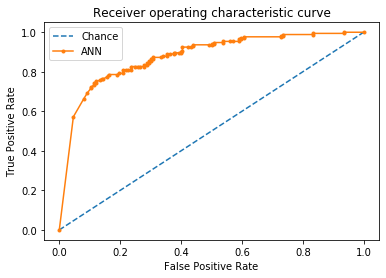

Logistic: f1=0.000 auc=0.889


C:\Users\wangh\Anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


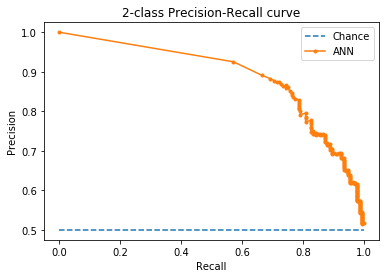

In [40]:
ANN()